# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверим *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измерим *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

- Загрузим необходимые библиотеки, датасет и получим общую информацию

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


### Изучив общую информацию по датасету, мы имеем:
1. Датасет состоит из 10000 клиентов;
2. Всего параметров в датасете 14. Из них Exited - целевой признак. Остальные позиции, за исключением RowNumber, CustomerId, Surname являются признаками для будущей модели.
3. В столбце Tenure имеются пропуски

- Проверим датасет на наличие дубликатов:

In [4]:
data['RowNumber'].nunique()

10000

Дубликатов нет

- Проверим датасет на наличие отрицательных значений:

In [5]:
check = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
data[data[check] < 0].count()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Отрицательных значений в численных данных нет

- Проверим столбец Tenure, где имеются пропуски

In [6]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [7]:
data['Tenure'] = data['Tenure'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Сделано предположение, что пропуски в столбце "количество недвижимости" означают отсутствие недвижимости у клиента. Исходя из этого, пропуски заменены на "0".

- Преобразуем категориальные признаки 'Geography', 'Gender' с помощью прямого кодирования. Для избежания дамми-ловушки, первый стобец удалим. 

In [8]:
category = ['Geography', 'Gender']
data_ohe = pd.get_dummies(data, columns=category, drop_first=True)
data_ohe

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,9997,15569892,Johnstone,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,9998,15584532,Liu,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,9999,15682355,Sabbatini,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


- Для исследований выделим обучающую, валидационную и обучающую выборки

In [45]:
target = data_ohe['Exited']
drop = ['RowNumber', 'CustomerId', 'Surname', 'Exited']
features = data_ohe.drop(columns=drop, axis=1)
features_train, features_testing, target_train, target_testing = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_testing, target_testing, test_size=0.5, random_state=12345)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


- Приведем признаки к одному масштабу

In [87]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.073677,-0.752805,-0.182016,-1.233163,0.830152,0,1,-1.278361,0,0,1
4094,-1.447531,-0.942612,1.748053,-1.233163,0.830152,0,1,-1.281307,0,0,1
3492,0.027113,0.575842,-1.468729,-0.310229,-0.891560,0,1,-0.903158,0,0,0
2177,0.151731,-1.417129,-0.182016,-1.233163,0.830152,0,1,-1.128539,0,0,0


# 2. Исследование задачи

- Определим долю клиентов, которые отказались от услуг банка:

In [13]:
data_ohe['Exited'].mean()

0.2037

20 % отказавшихся говорит о несбалансированности классов

- Покажем разницу между классами наглядно:

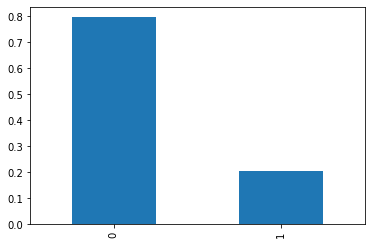

In [14]:
class_frequency = data_ohe['Exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar')

- Проверим работу модели на несбалансированных классах и сравним со случайной моделью

In [15]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(features_train, target_train)
def metrics(model):
    predicted = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('F1-мера:', f1_score(target_valid, predicted))
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))
metrics(model_1)

F1-мера: 0.33389544688026984
AUC-ROC: 0.7586317967081824


In [16]:
target_pred_constant = pd.Series([random.randint(0, 1) for i in range(len(features_valid.index))])
print(f1_score(target_valid, target_pred_constant))

0.2762508809020437


### Выводы:
1. В данных присутствует большой дисбаланс классов 80 : 20
2. Результаты F1-меры обученной модели и случайной на несбалансированных классах примерно равны.

# 3. Борьба с дисбалансом

- Сравним несколько вариантов борьбы с дисбалансом, а именно увеличение выборки, уменьшение выборки и взвешивание классов и примем наиболее оптимальный

## Увеличение выборки

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)## Уменьшение выборки

## Уменьшение выборки

In [18]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

## Сравнение вариантов борьбы с дисбалансом

- Сравним результаты работы моделей логической регрессии, решающего дерева и случайного леса с использованием разных способов борьбы с дисбалансом

### Модель логической регрессии

In [19]:
model_2 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_4 = LogisticRegression(random_state=12345, solver='liblinear')
model_2.fit(features_train, target_train)
model_3.fit(features_upsampled, target_upsampled)
model_4.fit(features_downsampled, target_downsampled)
print('Взвешивание классов:')
metrics(model_2)
print('Увеличение выборки:')
metrics(model_3)
print('Уменьшение выборки:')
metrics(model_4)

Взвешивание классов:
F1-мера: 0.4888888888888888
AUC-ROC: 0.7635798063138539
Увеличение выборки:
F1-мера: 0.4888888888888888
AUC-ROC: 0.7634769748183815
Уменьшение выборки:
F1-мера: 0.4892703862660944
AUC-ROC: 0.762673981816972


### Модель решающего дерева

In [20]:
model_5 = DecisionTreeClassifier(random_state=12345, max_depth=2, class_weight='balanced')
model_6 = DecisionTreeClassifier(random_state=12345, max_depth=2)
model_7 = DecisionTreeClassifier(random_state=12345, max_depth=2)
model_5.fit(features_train, target_train)
model_6.fit(features_upsampled, target_upsampled)
model_7.fit(features_downsampled, target_downsampled)
print('Взвешивание классов:')
metrics(model_5)
print('Увеличение выборки:')
metrics(model_6)
print('Уменьшение выборки:')
metrics(model_7)

Взвешивание классов:
F1-мера: 0.541015625
AUC-ROC: 0.7501814673449512
Увеличение выборки:
F1-мера: 0.541015625
AUC-ROC: 0.7501814673449512
Уменьшение выборки:
F1-мера: 0.5394495412844036
AUC-ROC: 0.7578892928217568


### Модель случайного леса

In [21]:
model_8 = RandomForestClassifier(random_state=12345, max_depth=10, class_weight='balanced')
model_9 = RandomForestClassifier(random_state=12345, max_depth=10)
model_10 = RandomForestClassifier(random_state=12345, max_depth=10)
model_8.fit(features_train, target_train)
model_9.fit(features_upsampled, target_upsampled)
model_10.fit(features_downsampled, target_downsampled)
print('Взвешивание классов:')
metrics(model_8)
print('Увеличение выборки:')
metrics(model_9)
print('Уменьшение выборки:')
metrics(model_10)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Взвешивание классов:
F1-мера: 0.608092485549133
AUC-ROC: 0.8356480501333785
Увеличение выборки:
F1-мера: 0.5978494623655913
AUC-ROC: 0.8344186088713337
Уменьшение выборки:
F1-мера: 0.55475763016158
AUC-ROC: 0.8240424573098072


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<font color='green'>Молодец, что рассматриваешь разные модели и способы борьбы с дисбалансом. </font>


### Данные способы борьбы с дисбалансом показывают идентичные результаты. Подберем лучшие гиперпараметры для моделей решающего дерева и случайного леса

- Найдем оптимальное значение гиперпараметров для модели случайного леса

In [132]:
model_11 = RandomForestClassifier(random_state=12345, class_weight='balanced')
param_grid = {
    'n_estimators': [i for i in range(15, 50, 5)],
    'max_depth': [i for i in range(5,15)],
    'min_samples_split': [i for i in range(2,8,2)],
    'min_samples_leaf': [i for i in range(1,6)]
}
search = GridSearchCV(model_11, param_grid, cv=5, scoring='f1')
search.fit(features_train, target_train)

In [133]:
search.best_params_

In [134]:
search.best_score_ 

- Найдем оптимальное значение гиперпараметров для модели решающего дерева

In [23]:
model_12 = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
param_grid = {
    'max_depth': [i for i in range(1,15)],
    'min_samples_split': [i for i in range(2,10,2)],
    'min_samples_leaf': [i for i in range(1,8)]
}
search = GridSearchCV(model_12, param_grid, cv=5, scoring='f1')
search.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=12345,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
   

In [24]:
search.best_params_

{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [25]:
search.best_score_ 

0.5605921352101073

- Обучим модели с лучшими гиперпараметрами

Модель случайного леса

In [26]:
model_13 = RandomForestClassifier(random_state=12345, 
                                  class_weight='balanced', 
                                  max_depth=10, 
                                  min_samples_leaf=5, 
                                  min_samples_split=2, 
                                  n_estimators=45)
model_14 = RandomForestClassifier(random_state=12345, 
                                  max_depth=10, 
                                  min_samples_leaf=5, 
                                  min_samples_split=2, 
                                  n_estimators=45)
model_15 = RandomForestClassifier(random_state=12345, 
                                  max_depth=10, 
                                  min_samples_leaf=5, 
                                  min_samples_split=2, 
                                  n_estimators=45)
model_13.fit(features_train, target_train)
model_14.fit(features_upsampled, target_upsampled)
model_15.fit(features_downsampled, target_downsampled)
print('Взвешивание классов:')
metrics(model_13)
print('Увеличение выборки:')
metrics(model_14)
print('Уменьшение выборки:')
metrics(model_15)

Взвешивание классов:
F1-мера: 0.6402714932126697
AUC-ROC: 0.8534061420647354
Увеличение выборки:
F1-мера: 0.6118143459915613
AUC-ROC: 0.8507657921956941
Уменьшение выборки:
F1-мера: 0.588560885608856
AUC-ROC: 0.847042687168444


Модель решающего дерева

In [27]:
model_16 = DecisionTreeClassifier(random_state=12345, 
                                  class_weight='balanced', 
                                  max_depth=7, 
                                  min_samples_leaf=7, 
                                  min_samples_split=2)
model_17 = DecisionTreeClassifier(random_state=12345, 
                                  max_depth=7, 
                                  min_samples_leaf=7, 
                                  min_samples_split=2)
model_18 = DecisionTreeClassifier(random_state=12345, 
                                  max_depth=7, 
                                  min_samples_leaf=7, 
                                  min_samples_split=2)
model_16.fit(features_train, target_train)
model_17.fit(features_upsampled, target_upsampled)
model_18.fit(features_downsampled, target_downsampled)
print('Взвешивание классов:')
metrics(model_16)
print('Увеличение выборки:')
metrics(model_17)
print('Уменьшение выборки:')
metrics(model_18)

Взвешивание классов:
F1-мера: 0.5753694581280788
AUC-ROC: 0.8236606197714722
Увеличение выборки:
F1-мера: 0.5705882352941176
AUC-ROC: 0.8188834919156297
Уменьшение выборки:
F1-мера: 0.5218165627782726
AUC-ROC: 0.8075138066404952


Результаты исследования показали, что лучшей моделью является модель случайного леса. Проведем тестирование для данной модели

# 4. Тестирование модели

- Проведем тестирование выбранной модели на валидационной выборке и получим показатель F1-меры

In [28]:
predicted_13 = model_13.predict(features_test)

In [29]:
probabilities_test = model_13.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('F1-мера:', f1_score(target_test, predicted_13))
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

F1-мера: 0.6179401993355481
AUC-ROC: 0.8546676440738693


### Задача выполнена. F1-мера превышает значение 0,59

# 5. Построим ROC-кривую

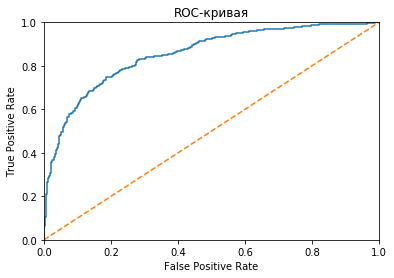

In [30]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

### Дополнительно для наглядности показана ROC-кривая (кривая ошибок) отражающая измеренную AUC-ROC